In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May 24 2024

@author: Yaning
"""

import os
import numpy as np
# from turtle import position
import torch
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean
import itertools
import pyro.distributions as dist

%run Documents/pyro_models/files_to_run/no_sigma_es_no_c_more_agents.py

/home/yaning/Documents/pyro_models/files_to_run/no_sigma_es_no_c_more_agents.py:24: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# initialise the param sample range (according to the already inferred results)
mean_u_list = np.linspace(-2., 2., 1000)
log_sigma_u_list = np.linspace(-2., 2., 1000)
log_a_list = np.linspace(-2., 2., 1000)
log_b_list = np.linspace(-2., 2., 1000)
log_beta_list = np.linspace(-2, 2.5, 1000)

param_list_list = [mean_u_list, log_sigma_u_list, 
                   log_a_list, log_b_list, log_beta_list]

# initialise environment values
repetition = 10
real_delays = [  1.,   2.,   3.,   4.,   6.,   7.,  13.,  14.,  23.,  24.,  29.,
        32.,  45.,  50.,  58.,  62.,  73.,  75., 118., 122.]
delays =  [i / 10 for i in real_delays]
SS_values = [20.]

# LL values by percentage of SS
LL_values_p = [1.02  , 1.025 , 1.0255, 1.05  , 1.055 , 1.08  , 1.085 , 1.15  ,
       1.2   , 1.25  , 1.33  , 1.35  , 1.45  , 1.47  , 1.5   , 1.55  ,
       1.65  , 1.7   , 1.83  , 1.85  , 1.9   , 2.05  , 2.07  , 2.25  ,
       2.3   , 2.5   , 2.55  , 2.8   , 2.85  , 3.05  , 3.1   , 3.45  ,
       3.5   , 3.8   , 3.85  ]

LL_values = []
for i in LL_values_p:
    LL_values.append(i*20.)

environment_list = [repetition, delays, SS_values, LL_values]

# get all the combinations of the arrays
combinations = list(itertools.product(environment_list[1], environment_list[2], environment_list[3]))
# every combination appears ten times
multiplied_array = [x for x in combinations for _ in range(environment_list[0])]
multiplied_array = np.array(multiplied_array)
trial_num = multiplied_array.shape[0]
whole = multiplied_array

In [3]:
def sample_param():
    mean_u = np.random.choice(param_list_list[0])
    log_sigma_u = np.random.choice(param_list_list[1])
    log_a = np.random.choice(param_list_list[2])
    log_b = np.random.choice(param_list_list[3])
    log_beta = np.random.choice(param_list_list[4])

    params = [mean_u, log_sigma_u,  
              log_a, log_b, log_beta]
    
    return params

In [4]:
# get the actions and add them to the data
def simulation(params):

    mean_u = params[0]
    mean_u = np.repeat([mean_u], trial_num)

    sigma_u = np.exp(params[1])
    sigma_u = np.repeat([sigma_u], trial_num)

    a = np.exp(params[2])
    a = np.repeat([a], trial_num)

    b = np.exp(params[3])
    b = np.repeat([b], trial_num)

    beta = np.repeat([np.exp(params[4])], trial_num)

    delay = 1/(1+b*np.exp(-a*whole[:,0]))

    # major calculation 
    inferred_estimation = (mean_u*delay**2 + 
                        whole[:,2]*sigma_u**2)/(delay**2 + sigma_u**2)
    
    inferred_sigma = ((sigma_u**2*delay**2)/(sigma_u**2 + delay**2))**0.5





    # change everything to tensor
    # whole = torch.tensor(whole)
    inferred_estimation = torch.tensor(inferred_estimation)
    inferred_sigma = torch.tensor(inferred_sigma)
    beta = torch.tensor(beta)

    e_dist  = dist.Normal(inferred_estimation, inferred_sigma)
    pos = 1 - e_dist.cdf(torch.tensor(20.))
    softmax_args = torch.stack([beta*pos, beta*(1-pos)])
    p = torch.softmax(softmax_args, dim = 0)[0]

    inferred_response_distr = dist.Bernoulli(probs=p)

    # get one possible predict actions
    inferred_response = inferred_response_distr.sample()

    return inferred_response

In [5]:
# if the percentage is lower than 0.1 or bigger than 0.9 then not using
# if the percentage fits the requirement then is good = 1
def check_percentage(params):
    good = 0
    inferred_response = simulation(params)
    choose_LL_percentage = len(list(filter(lambda x: (x == 1), inferred_response))
                            ) / len(inferred_response)
    if choose_LL_percentage > 0.10 and choose_LL_percentage < 0.90:
        good = 1
    return good, inferred_response, choose_LL_percentage

In [43]:
sample_num = 1000
agent_num = 50

# get an array of good parameters
good_params = []

while len(good_params) < sample_num:
    params = sample_param()
    if check_percentage(params)[0] == 1:
        good_params.append(params)
good_params = np.array(good_params)

KeyboardInterrupt: 

In [27]:
# get the actions for each agent with the good_params
# each agent sample from the good_params array
data = []
param = []
for i in range(agent_num):
    one_agent_param = good_params[np.random.choice(good_params.shape[0])]
    param.append(one_agent_param)
    one_agent_data = []
    while len(one_agent_data) == 0:
        good, inferred_response, choose_percentage = check_percentage(one_agent_param)
        if good == 1:
            one_agent_data = np.hstack((whole, inferred_response.reshape(-1,1)))
        print(choose_percentage)
    data.append(one_agent_data)

0.5362857142857143
0.597
0.4431428571428571
0.45714285714285713
0.5897142857142857


In [28]:
data = np.array(data)
param = np.array(param)

Mean ELBO 23895.20: 100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 57.78it/s]


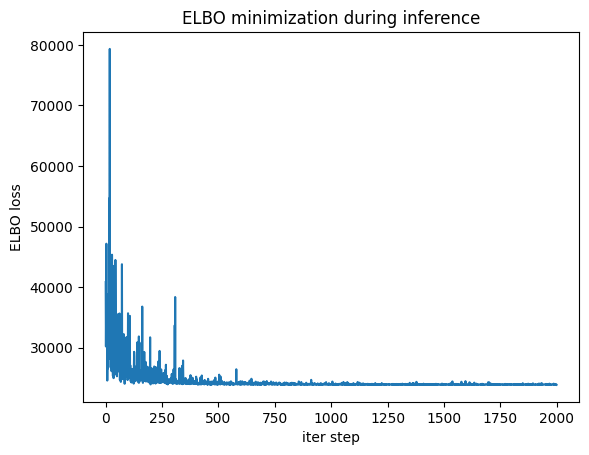

In [29]:
# doing inference

real_data = data
real_data = torch.tensor(real_data).to('cuda')
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
# the step was 2000
n_steps = 2 if smoke_test else 2000

# assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()# setup the optimizer
# the learning rate was 0.0005 , "betas": (0.90, 0.999)
# tried "n_par":15 in adam params but it does not have this argument
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
# svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(real_data)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    # for name, value in pyro.get_param_store().items():
    #     print(name, pyro.param(name))
    if torch.isnan(loss[-1]):
        break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")

# plt.savefig(str(param_list[i][j]) +'.png')

post_dict = {}
for name, value in pyro.get_param_store().items():
    post_dict[name] = value


In [31]:
pos_dict = {}
for name, value in pyro.get_param_store().items():
    pos_dict[name] = value

# change the dictionary to numpy instead of tensor
# because somehow the tensor cannot be save with pickle
numpy_dict = {key: value.cpu().detach().numpy() for key, value in pos_dict.items()}

In [33]:
numpy_dict['m_locs']

array([[ 0.36576322,  0.4384    , -0.85483503, -0.47723302, -1.3537744 ],
       [ 0.955042  ,  1.114279  , -1.2909236 ,  0.78356314, -1.0588945 ],
       [-0.90633136, -1.4585018 ,  0.7287975 , -1.1449854 , -1.6436579 ],
       [-0.670776  , -1.5239116 ,  0.87163144, -0.8542058 , -1.8456273 ],
       [ 0.87197506,  1.1941795 , -1.152651  ,  0.5286217 , -1.191306  ]],
      dtype=float32)

In [34]:
param

array([[ 1.08308308,  0.1981982 , -1.74774775,  0.17817818, -1.33333333],
       [ 0.48648649,  1.25525526, -0.46246246,  1.27127127, -0.78378378],
       [ 1.32332332, -1.43143143,  1.95195195, -0.73073073, -1.64414414],
       [ 1.32332332, -1.43143143,  1.95195195, -0.73073073, -1.64414414],
       [ 0.48648649,  1.25525526, -0.46246246,  1.27127127, -0.78378378]])

In [37]:
both_dict = {}
both_dict['real_param'] = param
both_dict['inferred_param'] = numpy_dict

In [41]:
import pickle
# save the dictionary
with open('Documents/pyro_models/files_to_run/results/test.pkl', 'wb') as f:
    pickle.dump(both_dict, f)